### Importing Libraries

In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
import glob
import shutil
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import vgg16 

### Create Generator

In [2]:
train_data_path = "../input/fer2013/train" 
test_data_path = "../input/fer2013/test"

In [3]:
def create_generator(batch_size, train_data_path, test_data_path):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1/255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    train_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "training"
    )
    
    val_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "validation"
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           horizontal_flip=True)
    
    test_generator = test_preprocesser.flow_from_directory(
        test_data_path,
        class_mode = "categorical",
        target_size=target_size,
        shuffle = True,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [4]:
batch_size = 32

train_generator, val_generator, test_generator = create_generator(batch_size, train_data_path, test_data_path)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### VGG Model

In [5]:
def VGG(number_of_classes):
    
    model = models.Sequential()
    
    pretrained_model = vgg16.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         classes = number_of_classes, 
                                         input_shape=(48,48,3))
    
    pretrained_model.trainable = True
    
    model.add(pretrained_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())

    model.add(Dense(256,activation="relu", kernel_regularizer = tf.keras.regularizers.l2(0.01)))
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(7, activation="softmax"))
    
    return model

In [7]:
number_of_classes = train_generator.num_classes
model_VGG = VGG(number_of_classes)
model_VGG.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [8]:
epochs = 50

path_to_save_model_vgg = "/content/DataMiningProject/Models/vgg.h5"

ckpnt_saver = ModelCheckpoint(
    path_to_save_model_vgg,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

model_VGG.compile(optimizer = "Adam",
                      loss = "categorical_crossentropy",
                      metrics = ["accuracy"]
                      )

history_vgg = model_VGG.fit(train_generator, 
                 epochs=epochs,
                 batch_size=batch_size,
                 validation_data = val_generator,
                 callbacks = ckpnt_saver
                 )

2022-05-22 13:32:37.316810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-22 13:32:40.012582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


718/718 [==============================] - 170s 224ms/step - loss: 2.0868 - accuracy: 0.2457 - val_loss: 1.8252 - val_accuracy: 0.2513

Epoch 00001: val_accuracy improved from -inf to 0.25135, saving model to /content/DataMiningProject/Models/vgg.h5
Epoch 2/50
718/718 [==============================] - 62s 87ms/step - loss: 1.8024 - accuracy: 0.2583 - val_loss: 1.8376 - val_accuracy: 0.2515

Epoch 00002: val_accuracy improved from 0.25135 to 0.25152, saving model to /content/DataMiningProject/Models/vgg.h5
Epoch 3/50
718/718 [==============================] - 62s 86ms/step - loss: 1.7304 - accuracy: 0.2923 - val_loss: 1.7056 - val_accuracy: 0.2998

Epoch 00003: val_accuracy improved from 0.25152 to 0.29977, saving model to /content/DataMiningProject/Models/vgg.h5
Epoch 4/50
718/718 [==============================] - 62s 86ms/step - loss: 1.6956 - accuracy: 0.3017 - val_loss: 1.7745 - val_accuracy: 0.2799

Epoch 00004: val_accuracy did not improve from 0.29977
Epoch 5/50
718/718 [======

In [9]:
print("Evaluating train set: ")
model_VGG.evaluate(train_generator)

print("Evaluating test set: ")
model_VGG.evaluate(test_generator)

Evaluating train set: 
718/718 [==============================] - 45s 63ms/step - loss: 0.7525 - accuracy: 0.7312
Evaluating test set: 
225/225 [==============================] - 47s 210ms/step - loss: 3.1677 - accuracy: 0.6248


[3.1676535606384277, 0.6248258352279663]

In [10]:
def show_acc_and_loss(model):    
    plt.figure(figsize=(14,6))

    train_acc = model.history["accuracy"]
    train_loss = model.history["loss"]

    plt.subplot(1,2,1)
    plt.plot(model.history["accuracy"])
    plt.plot(model.history["val_accuracy"])
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(model.history["loss"])
    plt.plot(model.history["val_loss"])
    plt.title("Train and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])

    plt.show()

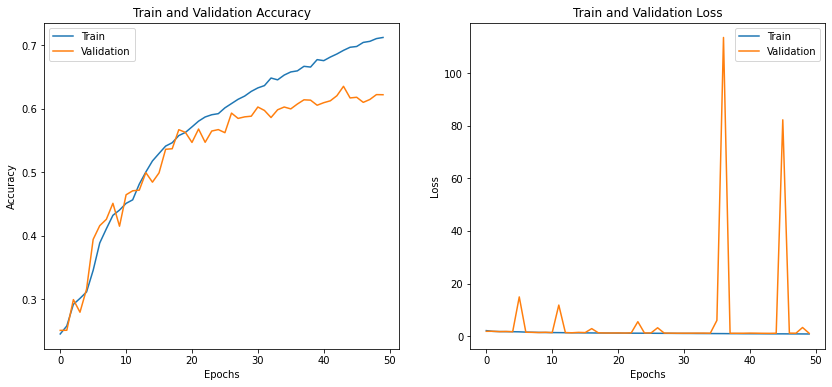

In [12]:
show_acc_and_loss(history_vgg)

In [15]:
def prediction_on_test_image(model, test_img):   
    dictionary = train_generator.class_indices

    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img.reshape(1,48,48,3)
    result = model.predict(test_img)
    result = list(result[0])
    #print(result)

    img_index = result.index(max(result))

    key = [key for key,value in dictionary.items() if value==img_index]
    
    return key[0]

TRAIN


<Figure size 720x1152 with 0 Axes>

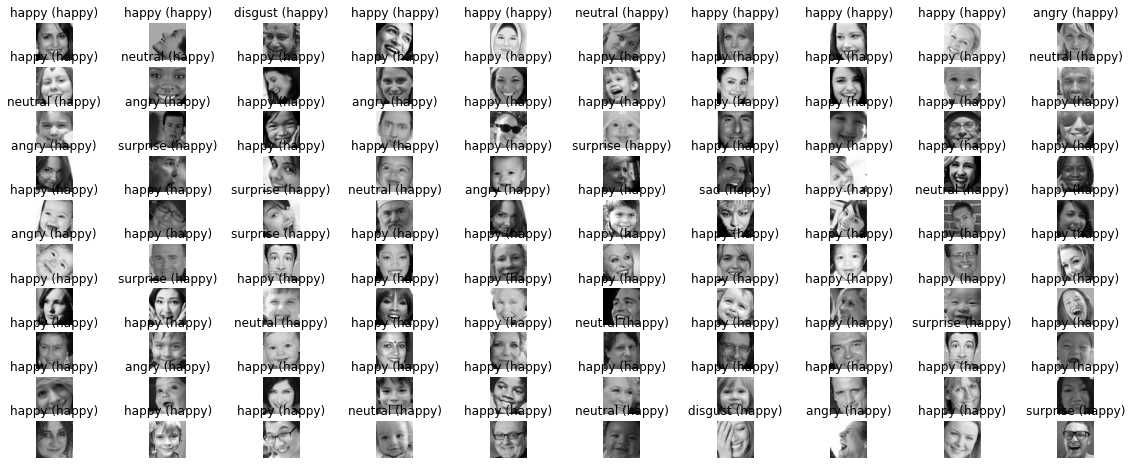

In [16]:
def plot_test_images(class_name, test_data_path, model):
    plt.figure(figsize=(10,16))
    
    class_labels = test_generator.class_indices
    figure = plt.figure(figsize=(20, 8))

    i=10
    j=10

    image_size=(48,48)

    for exp in os.listdir(test_data_path):
        if exp == class_name:
            full_path = os.path.join(test_data_path, class_name)
            images_path = glob.glob(os.path.join(full_path, '*.jpg'))
            for k in range(100):
                random_image_name = random.choice(images_path)
                #print(random_image_name)

                img = image.load_img(random_image_name, target_size=(48,48))
                
                predict_class = prediction_on_test_image(model, img)
                
                true_index = class_name
                
                ax = figure.add_subplot(10, 10, k+1)
                ax.set_title("{} ({})".format((predict_class), (true_index)))
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                
print("TRAIN")
plot_test_images("happy", test_data_path, model_VGG);

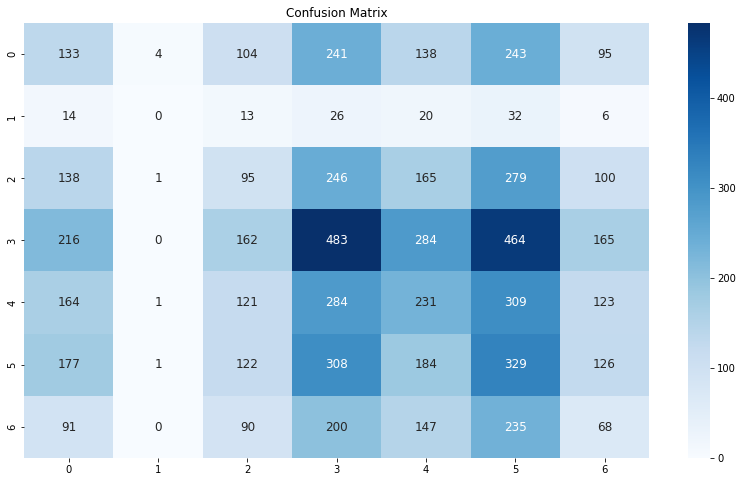

In [17]:
from sklearn.metrics import confusion_matrix


y_pred = model_VGG.predict(test_generator)
pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})